In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from tqdm import tqdm  # Import tqdm for progress bar
import seaborn as sns
from myMLlib import set_seed, load_data_list, rebalance_weight, plt_loss, plt_confusion
# from torch.utils.data import DataLoader, TensorDataset

In [2]:
folderpath= ('/home/yuqster/files/research/dataset/New_bloodmeat10')


materials = ['blood','meat']

In [5]:
data_list,labels = load_data_list([folderpath],materials)

In [6]:
set_seed(40)
X = np.array(data_list).squeeze()
y = np.array(labels).reshape(-1,1)
print(X.shape)
print(y.shape)

(95859, 4096)
(95859, 1)


In [7]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [8]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=47)
# scaler = RobustScaler(
#     with_centering=True,    # 是否减去中位数，默认为 True
#     with_scaling=True,      # 是否除以 IQR（默认 True）
#     quantile_range=(30.0, 70.0)  # 用于计算 IQR 的上下分位数，默认为 (25, 75)
# )
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train,1)
# X_test = scaler.transform(X_test)
# X_r_test = scaler.transform(X_r_test)
# joblib.dump(scaler, '/home/yuqster/files/research/model/scaler.pkl')

scaler = MinMaxScaler(feature_range=(0, len(materials)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)



print(X_train.shape)
print(y_train.shape)


(57515, 4096)
(57515, 1)


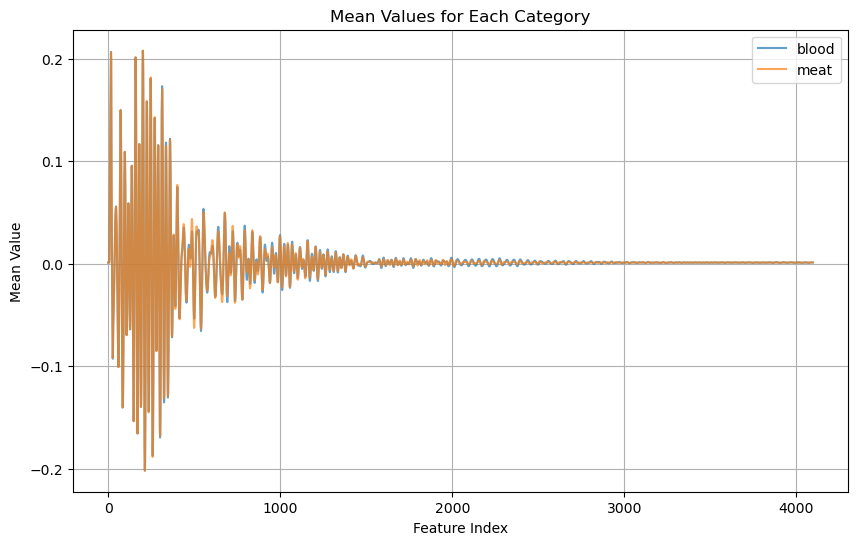

In [9]:
unique_labels = np.unique(y_train)
indices1 = {}
indices2 = {}
plt.figure(figsize=(10,6))
for i,label in enumerate(unique_labels):
    # 获取当前类别下的样本索引
    indices1[materials[i]] = np.where(y_train.flatten() == label)
    # 计算当前类别 X 中所有样本的特征均值（按列均值）
    mean_values = X_train[indices1[materials[i]]].mean(axis=0)
    # 绘制均值曲线
    plt.plot(mean_values, label=f"{materials[int(label)]}",alpha = 0.7)
plt.xlabel("Feature Index")
plt.ylabel("Mean Value")
plt.title("Mean Values for Each Category")
plt.legend()
plt.grid(True)
plt.show()



In [10]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256,64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 2)




    def forward(self, i):
        h1 = torch.tanh(self.fc1(i))
        h2 = torch.tanh(self.fc2(h1))
        h3 = torch.tanh(self.fc3(h2))
        o = self.fc4(h3)
        return o



In [11]:
model = ANN_Model().to(device)

class_weights,_ = rebalance_weight(y_train)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.AdamW(model.parameters(), lr=1e-5)
# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).squeeze().to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).squeeze().to(device)

In [12]:
# 5. 训练模型
num_epochs = 10000
train_losses = []
test_losses = []

pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    # —— 2. 验证 —— #
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)    # 假设你已有 X_test_tensor
        test_loss = criterion(test_outputs, y_test_tensor)
        test_losses.append(test_loss.item())

    # —— 3. 更新 tqdm 的显示 —— #
    pbar.set_postfix(train_loss=loss.item(), test_loss=test_loss.item())

Training: 100%|██████████| 10000/10000 [03:57<00:00, 42.04it/s, test_loss=0.0221, train_loss=0.0218]


In [13]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.9995566451074483
Accuracy_train: 0.9997044249326262
Confusion Matrix:
[[19026    17]
 [    0 19301]]


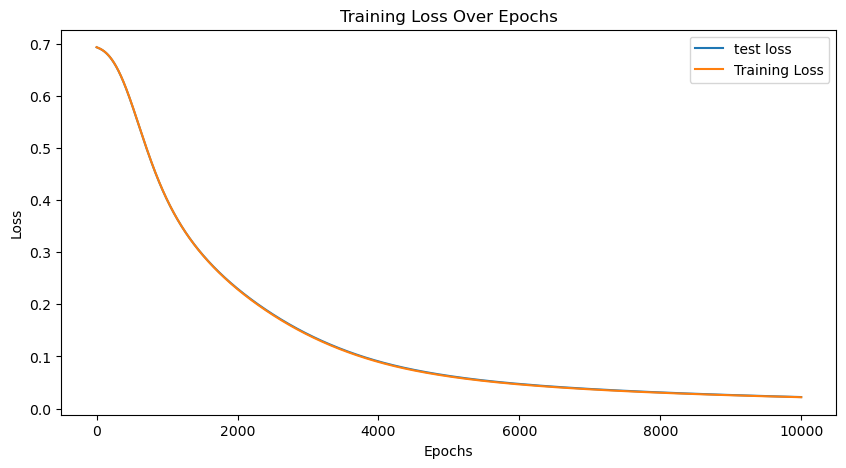

In [14]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

plt_loss(train_losses=train_losses,test_losses= test_losses)

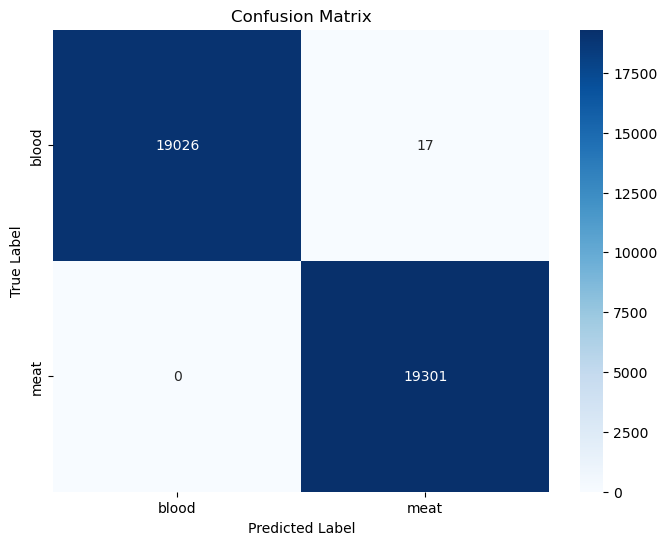

Accuracy: 0.9995566451074483
              precision    recall  f1-score   support

       blood       1.00      1.00      1.00     19043
        meat       1.00      1.00      1.00     19301

    accuracy                           1.00     38344
   macro avg       1.00      1.00      1.00     38344
weighted avg       1.00      1.00      1.00     38344



In [15]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=materials,
            yticklabels=materials)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=materials, labels=range(len(materials)))
print("Accuracy:", accuracy)
print(report)

In [16]:
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor.to(device))    # [N,2]
    
    # 方法 A：用 softmax 概率
    probs = torch.softmax(logits, dim=1)           # [N, 2]
    all_scores = probs[:, 1].cpu().numpy()         # 正类概率 ∈ [0,1]
    all_labels = y_test  # shape (N,)

In [17]:
fpr, tpr, thresholds = roc_curve(all_labels, all_scores)
roc_auc = roc_auc_score(all_labels, all_scores)

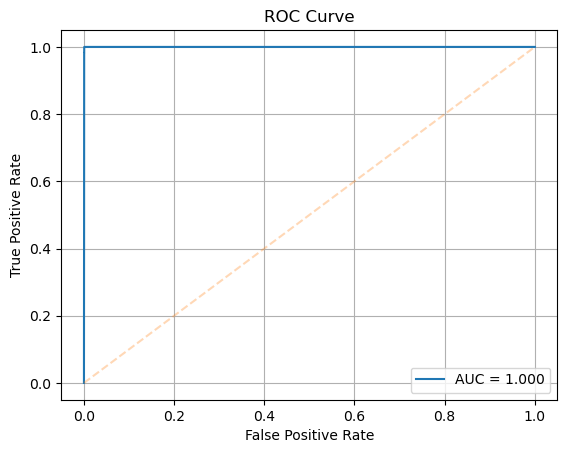

In [18]:
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], '--', alpha=0.3)   # 对角参考线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [35]:
with torch.no_grad():
    model.fc4.bias = nn.Parameter(torch.tensor([ 1, -0.0134], device='cuda:0', requires_grad=True))
    print(model.fc4.bias)

Parameter containing:
tensor([ 1.0000, -0.0134], device='cuda:0', requires_grad=True)


Accuracy: 0.9996609639056958


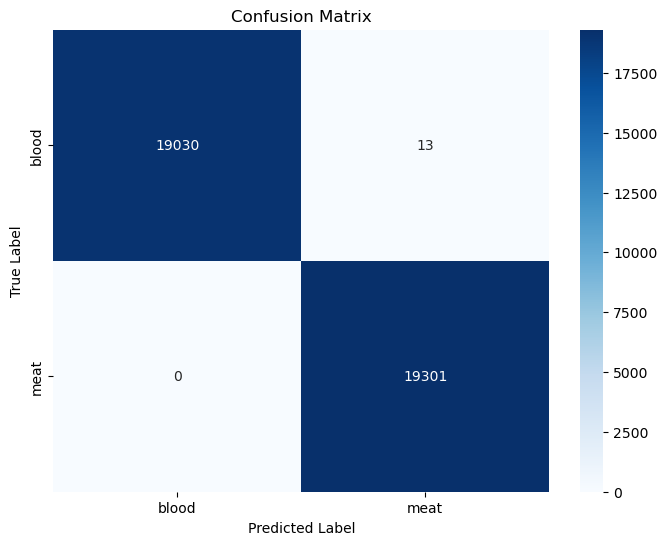

In [36]:
model.eval()
with torch.no_grad():
    r_test_outputs = model(X_test_tensor)
    _, predicted = torch.max(r_test_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    r_accuracy = accuracy_score(y_test, predicted_np)
    r_cm = confusion_matrix(y_test, predicted_np)
print(f'Accuracy: {r_accuracy}')
plt_confusion(r_cm,materials)